# Mittelstufenprojekt Rossmann Sales Prediction
Das folgende Projekt befasst sicht mit dem Datensatz der "Rossman Store Sales".
Ziel des Projekts ist es, ein Vorhersagenmodell zu entwickeln, das den Umsatz von Rossmann-Filialen möglichst genau vorhersagen kann.
Das Projekt umfasst folgende Schritte:
* Das Laden der Daten
* Explorative Datenanalyse
* Data Cleaning
* Feature Engeneering
* Modellbildung und Anwendung von XGBoost
* Hyperparameter Tuning (GridseachCV)
* Submission für die test.csv erstellen und bei Kaggle hochgeladen

Abschließend werden zwei reißerische Grafiken mit jeweils einer Einsicht auf Basis der KI-Modelle erstellt.

## Kaptiel 1: Insights
### Im ersten Kapitel geht es zunächst darum, anhand der unbearbeiteten Daten festzustellen, welche features (Spalten) für die folgende Vorhersage von Bedeutung sind und welche nicht. Diese würden anschließlich im DataCleaning entfernt werden um die Ergebnisse im diesem Test nicht zu verfälschen.

In [1]:
# Zunächst werden die grundelegend benötigten Bibliotheken importiert.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# Anschließend werden die Daten eingelesen und in Dataframes gespeichert.

df1 = pd.read_csv("store.csv")
df2 = pd.read_csv("train.csv")

/tmp/ipykernel_26490/3594182790.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("train.csv")


In [3]:


# Die Zeilen werden nach ID zusammengefasst, die Summe der Werte werden gebildet und in einer neuen Tabelle gespeichert um doppelte Einträge zu vermeiden.
df3 = df2.groupby("Store").sum()

df3.head()


/tmp/ipykernel_26490/3858165791.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3 = df2.groupby("Store").sum()


,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Store,,,,,,
1,3766,3716854,440523,781,360,193
2,3766,3883858,457855,784,360,167
3,3766,5408261,584310,779,360,170
4,3766,7556507,1036254,784,360,173
5,3766,3642818,418588,779,360,172


<Axes: >

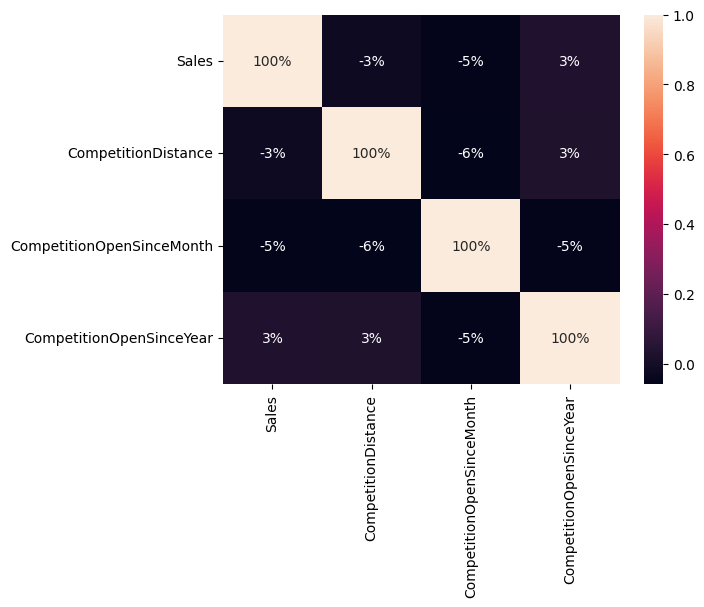

In [4]:
# Das eben zusammengefasste Dataframe wird nun mit dem ersten Dataframe zusammengeführt um den Einfluss der Wettbewerber (Competition) auf die Sales zu bestimmen.
df_merged = pd.merge(df1, df3, on="Store")
df_merged.head()

#
#die Korrelation zwischen den Spalten Sales und CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear wird in einer Heatmap dargestellt.
sns.heatmap(df_merged[["Sales", "CompetitionDistance", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]].corr(), annot=True, fmt=".0%")

### Als nächstes wird ein genauer Blick auf den Zusammenhang zwischen Sales und dem Wochentag geworfen, um zu sehen, ob es irgendwelche auffälligkeiten zwischen den Wochentagen gibt.
Dafür wird ein neues Dataframe mit dem Namen df_date erstellt, hier werden anders als bei df_merged die Store_IDs nicht zusammengefasst, um den Unterschied zwischen den Wochentagen hervorheben zu können.

In [5]:
df_date = pd.merge(df1, df2, on="Store")
df_date.head(5) 

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,2015-07-27,6102,612,1,1,0,1


<Axes: xlabel='DayOfWeek', ylabel='Sales'>

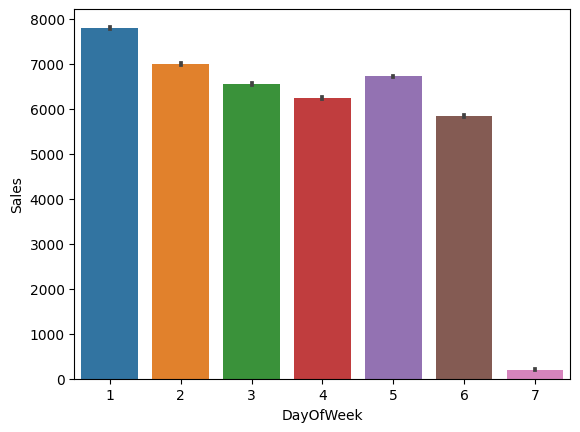

In [6]:
# Die Sales werden nach Wochentag gruppiert und in einem Säulendiagramm dargestellt.
sns.barplot(x="DayOfWeek", y="Sales", data=df_date)


Anhand des Graphen kann man erkennen, dass montags, dienstags und freitags in der Regel die höchsten Umsätze generiert werden

<Axes: >

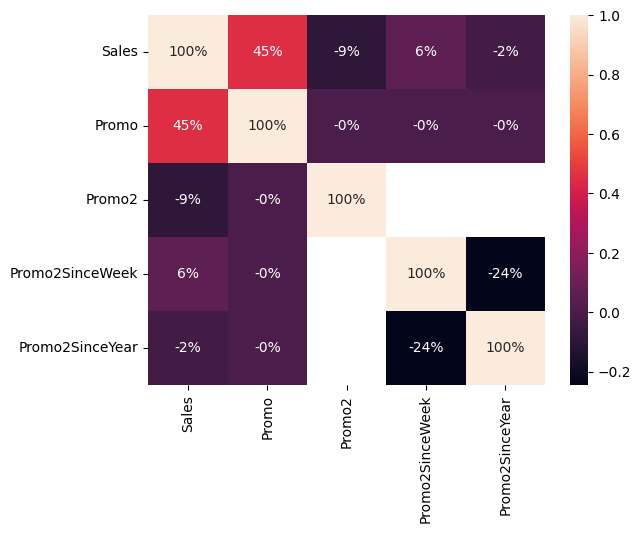

In [7]:
# Es wird eine Heatmap erstellt, um die Korrelation zwischen Sales und Promo, Promo2, Promo2SinceWeek und Promo2SinceYear zu bestimmen.
sns.heatmap(df_date[["Sales", "Promo", "Promo2", "Promo2SinceWeek", "Promo2SinceYear"]].corr(), annot=True, fmt=".0%")

## Fazit Kapitel 1:
Anhand der Insights haben wir wichtige Features erkannt, welche für die spätere Auswertung beziehungsweise Vorhersage relevant sind.
Ebenso haben wir uninteressante Features gefunden, welche für den folgenden Verlauf nicht relevant sind und somit entfernt wurden.

## Kapitel 2: Data Cleaning
### Nachdem in den Insights die Daten betrachtet und nach der Wichtigkeit ausgewertet worden sind, geht es in diesem Kapitel um das DataCleaning, welches die Daten so aufbereitet, dass die KI-Modelle im späteren Verlauf mit diesen Daten arbeiten können und somit möglichst genaue Vorhersagen treffen kann

Es wird noch einmal ein Blick auf die Daten geworfen, nun mit dem Ziel, sie mittels Datacleaning Methoden für die KI-Verfahren nuztbar zu machen

In [8]:
# kurzer Überblick über die Daten in dem Dataframe df1.
print(df1.shape[0])
print(df1.info())
df1.head(10)

1115
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [9]:
# Ein kurzer Überblick über die Daten in dem Dataframe df2.

print(df2.shape[0])
print(df2.info())
df2.head(10)

1017209
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
6,7,5,2015-07-31,15344,1414,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
9,10,5,2015-07-31,7185,681,1,1,0,1


## Competition Spalten entfernen
Da wir durch eine Analyse der Korrelation herausgefunden haben, dass die Spalten "CompetitionOpenSinceMonth" und "CompetitionOpenSinceYear" nur geringfügig mit den "Sales" zusammenhängen und wir zuvor gesehen haben, dass im df1 diese Werte bei mehrere hundert Zeilen werden diese aus dem Datenframe entfernt.

In [10]:

# Die Spalten CompetitionOpenSinceMonth und CompetitionOpenSinceYear werden entfernt.
df1.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis=1, inplace=True)

print(df1.info())
df1.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Store                1115 non-null   int64  
 1   StoreType            1115 non-null   object 
 2   Assortment           1115 non-null   object 
 3   CompetitionDistance  1112 non-null   float64
 4   Promo2               1115 non-null   int64  
 5   Promo2SinceWeek      571 non-null    float64
 6   Promo2SinceYear      571 non-null    float64
 7   PromoInterval        571 non-null    object 
dtypes: float64(3), int64(2), object(3)
memory usage: 69.8+ KB
None


,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,0,NaN,NaN,NaN
1,2,a,a,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,0,NaN,NaN,NaN
5,6,a,a,310.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,0,NaN,NaN,NaN


## Datacleaning Funktionen
### Da die Datacleaning Maßnahmen nicht nur bei dem Erstellen der KI-Modelle, sondern auch später beim testen mit den test.csv Daten und beim Erstellen der Submission benötigt werden, wurde für jede Maßnahme jeweils eine Funktion erstellt, sodass diese anstelle von Hardcoding genutzt werden können.

In [11]:
def drop_competition_cols(dataframe):
    dataframe.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis=1, inplace=True)
    return dataframe

In [12]:
# Eine Funktion für das mergen der Dataframes wird erstellt.
def merge_df(dataframe, dataframe2):
    return pd.merge(dataframe, dataframe2, on='Store', how='left')


In [13]:
# Funktion zum Splitten der Spalte Date in die Spalten Year, Month und Day wird erstellt.
def split_date(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Year'] = dataframe['Date'].dt.year
    dataframe['Month'] = dataframe['Date'].dt.month
    dataframe['Day'] = dataframe['Date'].dt.day
    return dataframe

## Promo2% und PromoInterval Spalten werden entfernt
Die Spalten "Promo2", "Promo2SinceWeek", "Promo2SinceYear" und PromoInterval werden entfernt, da diese zu wenig Einfluss auf die Sales haben und lediglich die Dauer der Promotion anzeigen, während der Fakt, das eine Promotion stattfindet, bereits durch die Spalte Promo geklärt wird. Darüber hinaus fehlen 50% der Datensätze, was eine Auswertung verfälschen würde.

In [14]:
# Funktion zum Entfernen der Spalten Promo2, Promo2SinceWeek, Promo2SinceYear und PromoInterval wird erstellt.
def drop_promo2_cols(dataframe):
    dataframe.drop(['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1, inplace=True)
    return dataframe

In [15]:
# Funktion zum Entfernen der Spalte Date wird erstellt.
def drop_date_col(dataframe):
    dataframe.drop(['Date'], axis=1, inplace=True)
    return dataframe

## Anpassung der Spalte Kunden

Da sich bei der späteren Analyse herausgestellt hat, dass die Spalte Kunden für das Vorhersagen der Sales ein wichtiges Kriterium für die KI Modelle ist, konnte diese Spalte nicht entfernt werden.

Da die Anzahl der Kunden allerdings immer an ein Datum gebunden ist und die Daten unterschiedlich bei dem train.csv und test.csv sind wurde aus der Gesamtanzahl der Kunden für jeden Store die durschnittliche Anzahl der Kunden gebildet.

Dadurch ist die Spalte Kunden nun nicht mehr abhängig von dem Datum und kann somit für die Vorhersage der Sales verwendet werden. 

In [16]:
# Funktion zum Umwandeln der Kunden in durchschnittliche Kunden.
def avg_customers(dataframe):
    for i in range(1, 1116):
        dataframe.loc[dataframe['Store'] == i, 'Customers'] = dataframe.loc[dataframe['Store'] == i, 'Customers'].mean()
    return dataframe


In [17]:
# Eine Funktion zum Ersetzen der 0 mit '0' wird erstellt, damit es beim Label Encoding zu keinem Fehler kommt.
def replace_zero(dataframe):
    dataframe['StateHoliday'] = dataframe['StateHoliday'].replace(0, '0')
    return dataframe


In [18]:
# Funktion zum füllen der CompetitionDistance mit dem Mittelwert.
def fill_competition_distance(dataframe):
    dataframe['CompetitionDistance'].fillna(dataframe['CompetitionDistance'].mean(), inplace=True)

In [19]:
# Funktion zum füllen der Spalte Open mit 1, wenn kein Wert vorhanden ist.
def fill_open(dataframe):
    # replace NaN with 1
    dataframe['Open'].fillna(1, inplace=True)

In [20]:
# Die Spalten StateHoliday, StoreType, Assortment werden in numerische Werte umgewandelt mittels Label Encoding.
from sklearn.preprocessing import LabelEncoder

# Eine Funktion zum Label Encoding wird erstellt.
def label_encoding(dataframe):
    le = LabelEncoder()
    dataframe['StateHoliday'] = le.fit_transform(dataframe['StateHoliday'])
    dataframe['StoreType'] = le.fit_transform(dataframe['StoreType'])
    dataframe['Assortment'] = le.fit_transform(dataframe['Assortment'])

    return dataframe

## Fazit Kapitel 2:
In diesem Kapitel ging es hauptsächlich um die Auswertung der Datensätze und der Bereinigung fehlerhafter Einträge.
Viele Spalten wurden entfernt, da wir sie nicht als wichtig genug eingestuft haben, um unsere Vorhersagen später zu treffen.
Zudem wurden alle Spalten in das richtige Format gebracht und replacements nötiger Zahlen getroffen.

## Kaptiel 3: KI Modelle 
### Im folgenden Kapitel geht es um die Anwendung von verschiedenen KI-Modellen, um die Sales eines Stores vorherzusagen.

In [21]:
#Die benötigten Bibliotheken für das Erstellen und Auswerten der KI-Modelle werden importiert.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing



In [22]:
# Anwendung der DataCleaning funktionen auf das Trainingsdatenset.
df_merged2 = merge_df(df1, df2)
split_date(df_merged2)
drop_promo2_cols(df_merged2)
drop_date_col(df_merged2)
replace_zero(df_merged2)
label_encoding(df_merged2)
avg_customers(df_merged2)
fill_competition_distance(df_merged2)
fill_open(df_merged2)

In [23]:
df_merged2.head(3000)

,Store,StoreType,Assortment,CompetitionDistance,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
0,1,2,0,1270.0,5,5263,467.646497,1,1,0,1,2015,7,31
1,1,2,0,1270.0,4,5020,467.646497,1,1,0,1,2015,7,30
2,1,2,0,1270.0,3,4782,467.646497,1,1,0,1,2015,7,29
3,1,2,0,1270.0,2,5011,467.646497,1,1,0,1,2015,7,28
4,1,2,0,1270.0,1,6102,467.646497,1,1,0,1,2015,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,4,2,2,620.0,4,8239,1100.057325,1,0,0,0,2015,2,12
2996,4,2,2,620.0,3,7317,1100.057325,1,0,0,0,2015,2,11
2997,4,2,2,620.0,2,7914,1100.057325,1,0,0,0,2015,2,10
2998,4,2,2,620.0,1,8940,1100.057325,1,0,0,0,2015,2,9


In [24]:
df_merged2.isnull().sum()

Store                  0
StoreType              0
Assortment             0
CompetitionDistance    0
DayOfWeek              0
Sales                  0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
Year                   0
Month                  0
Day                    0
dtype: int64

In [25]:
# Aus dem Dataframe df_merged2 wird ein neues Dataframe df_merged2_sample erstellt, welches 10000 zufällige Zeilen enthält
# um die Berechnungen nicht zu kompliziert und dadruch zu zeit- und ressourceaufwendig zu machen.

df_merged2_sample = df_merged2.sample(n=10000, random_state=1)

from sklearn.model_selection import train_test_split

# Die Spalte Sales wird als Zielvariable definiert
y = df_merged2_sample['Sales']

# Die Spalte Sales wird für die Erstellung der Modelle aus dem Dataframe entfernt
x = df_merged2_sample.drop(['Sales'], axis=1)

# Die Daten werden in Trainings- und Testdaten aufgeteilt
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Es wird eine Pipeline erstellt, um die Daten zu skalieren und das Random Forest Regressor Modell zu erstellen.

In [26]:

from sklearn import preprocessing
pipeline = make_pipeline(preprocessing.StandardScaler(),
                                     RandomForestRegressor(n_estimators=100,
                                                           random_state=123))

Verschiedene Hyperparameter ausprobieren und festlegen

In [27]:
hyperparameters = { 'randomforestregressor__max_features' : [2, 4],
                    'randomforestregressor__max_depth': [10, 5],
                    'randomforestregressor__n_estimators': [50, 200]}

GridSearchCV wird angewendet um die besten Hyperparameter zu erkennen

In [28]:
clf = GridSearchCV(pipeline, hyperparameters, cv=10)

# Fit and tune model
clf.fit(x_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=123))]),
             param_grid={'randomforestregressor__max_depth': [10, 5],
                         'randomforestregressor__max_features': [2, 4],
                         'randomforestregressor__n_estimators': [50, 200]})

Hier werden die besten Parameter ausgegeben

In [29]:
print( clf.best_params_ )

{'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 4, 'randomforestregressor__n_estimators': 200}


0.828307947899142


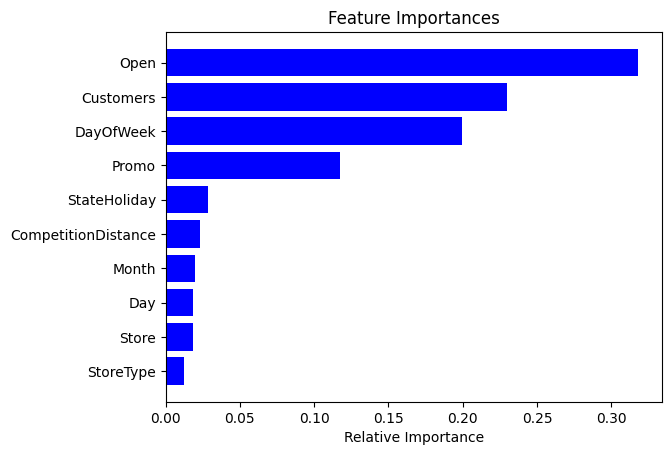

In [30]:
# Die Vorhersage wird mit dem Testdatensatz durchgeführt und der R2-Wert wird berechnet.
y_pred = clf.predict(x_test)
print( r2_score(y_test, y_pred) )

#Die wichtigsten Features werden in einem Balkendiagramm dargestellt
importances = clf.best_estimator_.named_steps['randomforestregressor'].feature_importances_
features = x.columns
indices = np.argsort(importances)[-10:]

# Eine Funktion zum Plotten der Feature Importance des RandomForests wird erstellt um sie später bei der Analyse erneut aufgreifen zu können.
def plot_feature_importances_rfr():
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

plot_feature_importances_rfr()

Accuracy: 0.7227462564695786


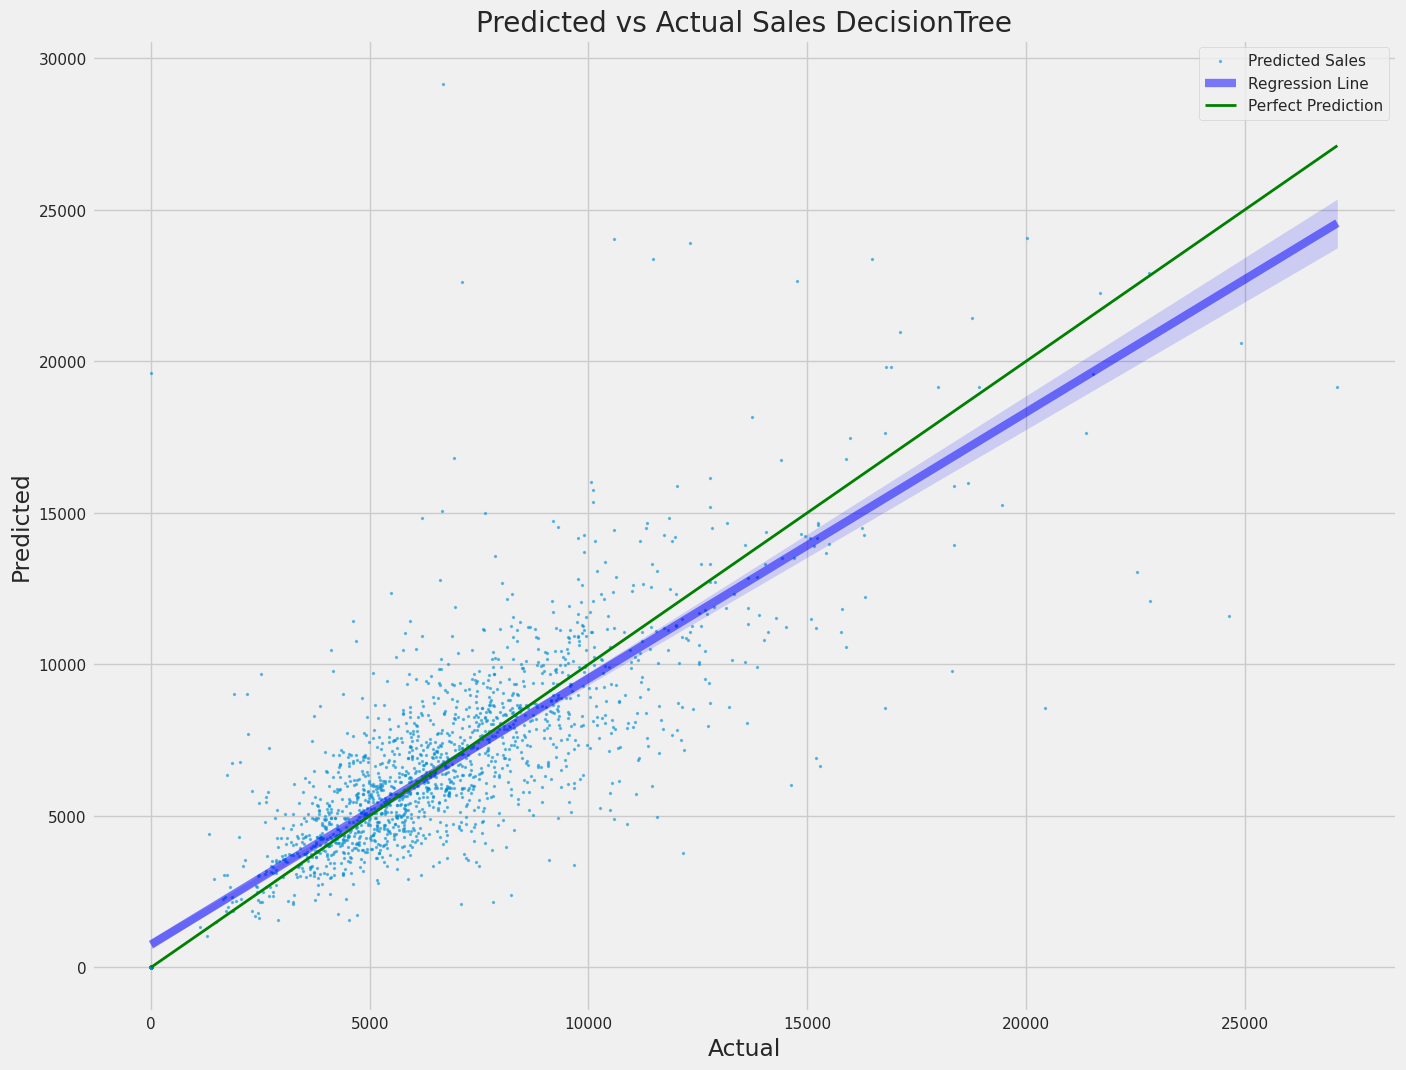

In [31]:
# Es wird ein DecisionTree erstellt.
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Es wird ein DecisionTreeRegressor erstellt.
regr = DecisionTreeRegressor(random_state=0)

# Der DecisionTreeRegressor wird mit den Trainingsdaten trainiert.
regr = regr.fit(x_train,y_train)

# Die Vorhersage wird mit dem Testdatensatz durchgeführt und der R2-Wert wird berechnet.
y_pred = regr.predict(x_test)

print("Accuracy:",r2_score(y_test, y_pred))

# Die tatsächliche und die prognostizierte Sales werden mit Regressionslinie und perfekter Vorhersagelinie dargestellt.
sns.set_theme(style='darkgrid')
plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,12))
sns.regplot(x=y_test, y=y_pred, truncate=True, scatter_kws={'alpha': 0.5, 's':2}, line_kws={'alpha': 0.5, 'label':'Regression Line', 'color':'blue'}, label='Predicted Sales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2, label='Perfect Prediction', color='green', alpha=1)
plt.title('Predicted vs Actual Sales DecisionTree')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()


##### Da die einelnen Schritte bei der Erstellung der einzelnen KI-Modelle sehr ähnlich sind werden im folgenden die Kommentare für die einzelnen Schritten weggelassen

Accuracy: 0.6587190583870968


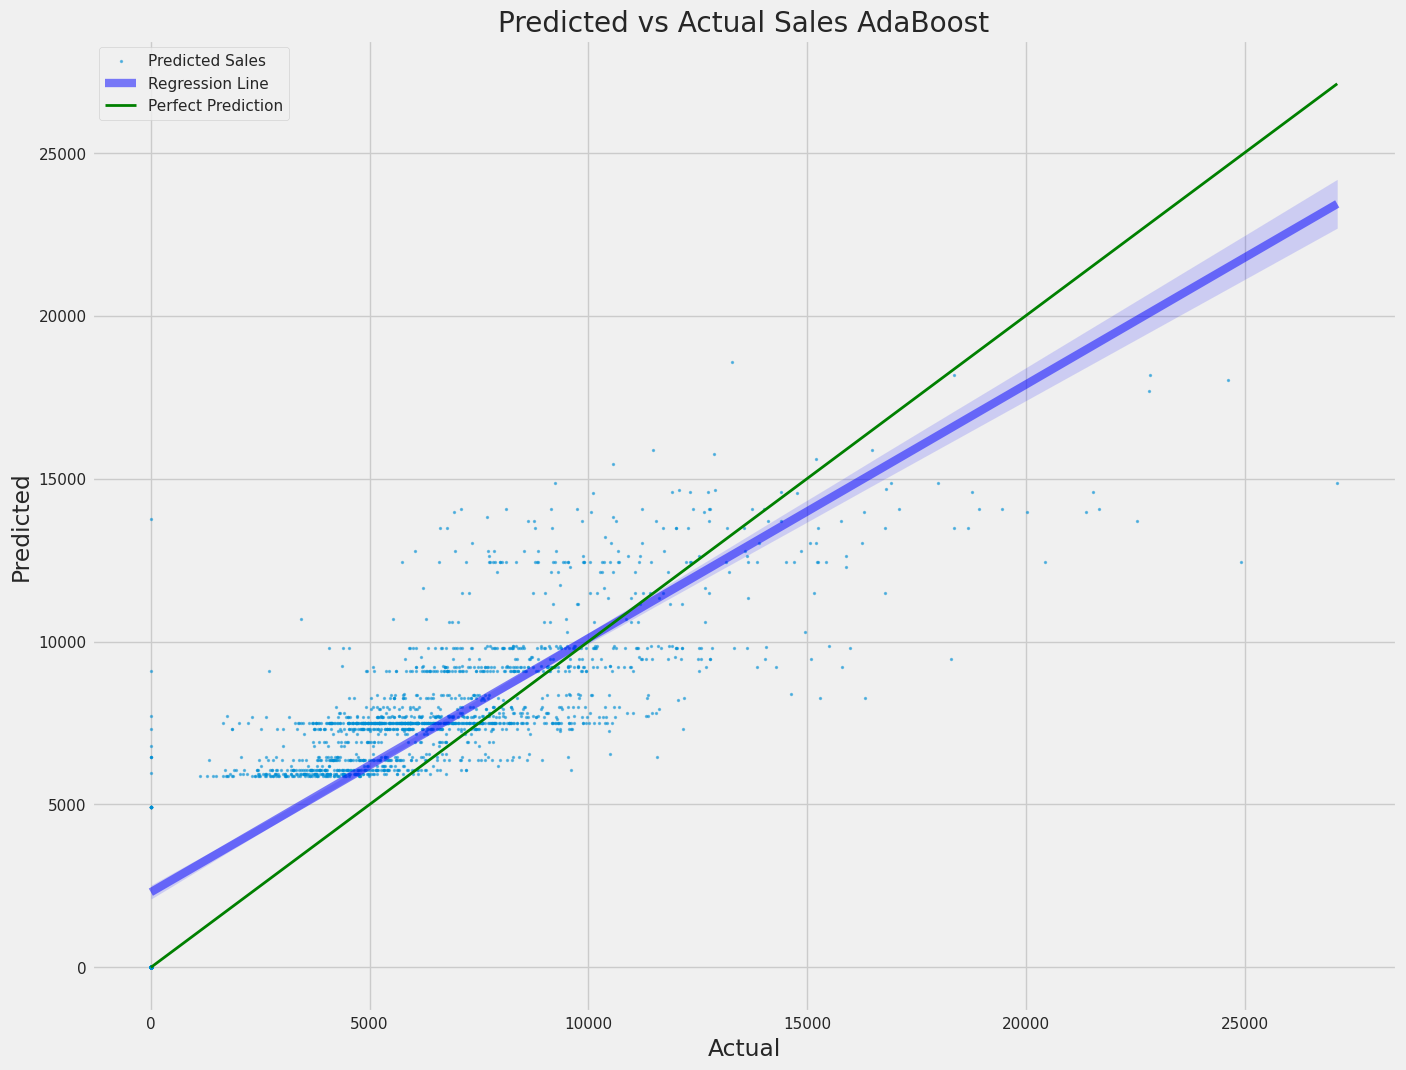

In [32]:
# Adaboost

from sklearn.ensemble import AdaBoostRegressor


regr = AdaBoostRegressor(random_state=0, n_estimators=100)


regr = regr.fit(x_train,y_train)


y_pred = regr.predict(x_test)

print("Accuracy:",r2_score(y_test, y_pred))

sns.set_theme(style='darkgrid')
plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,12))
sns.regplot(x=y_test, y=y_pred, truncate=True, scatter_kws={'alpha': 0.5, 's':2}, line_kws={'alpha': 0.5, 'label':'Regression Line', 'color':'blue'}, label='Predicted Sales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2, label='Perfect Prediction', color='green', alpha=1)
plt.title('Predicted vs Actual Sales AdaBoost')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

Accuracy: 0.8424380427208235


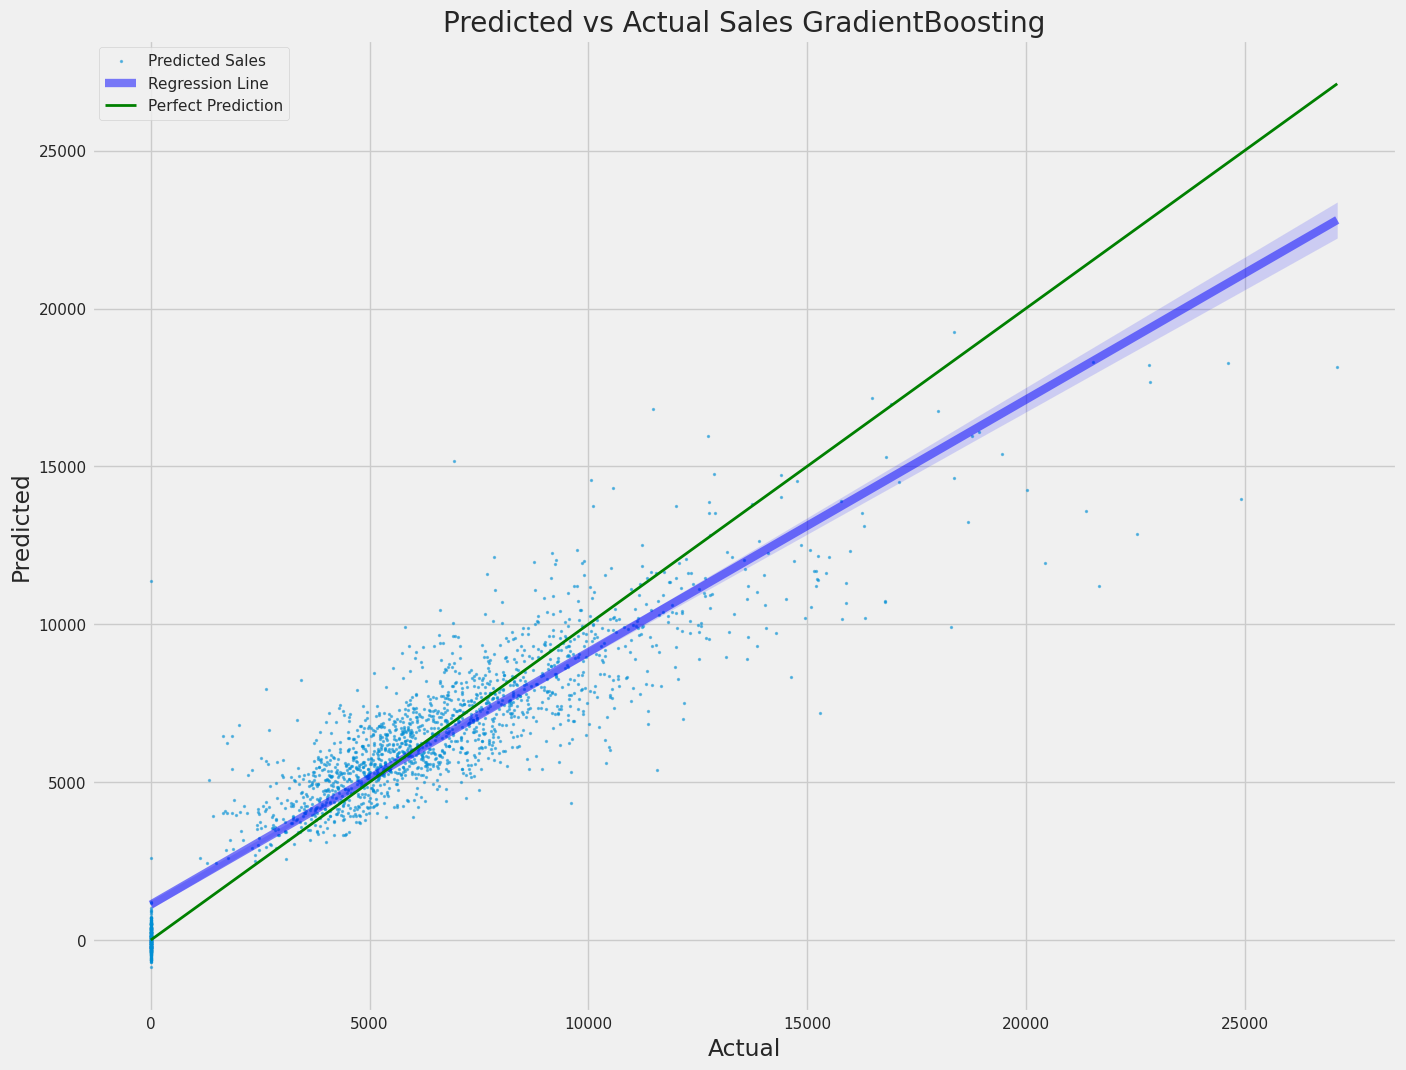

In [33]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor


regr = GradientBoostingRegressor(random_state=0, n_estimators=100)

regr = regr.fit(x_train,y_train)

y_pred = regr.predict(x_test)

print("Accuracy:",r2_score(y_test, y_pred))

sns.set_theme(style='darkgrid')
plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,12))
sns.regplot(x=y_test, y=y_pred, truncate=True, scatter_kws={'alpha': 0.5, 's':2}, line_kws={'alpha': 0.5, 'label':'Regression Line', 'color':'blue'}, label='Predicted Sales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2, label='Perfect Prediction', color='green', alpha=1)
plt.title('Predicted vs Actual Sales GradientBoosting')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

Accuracy: 0.1894546234902692


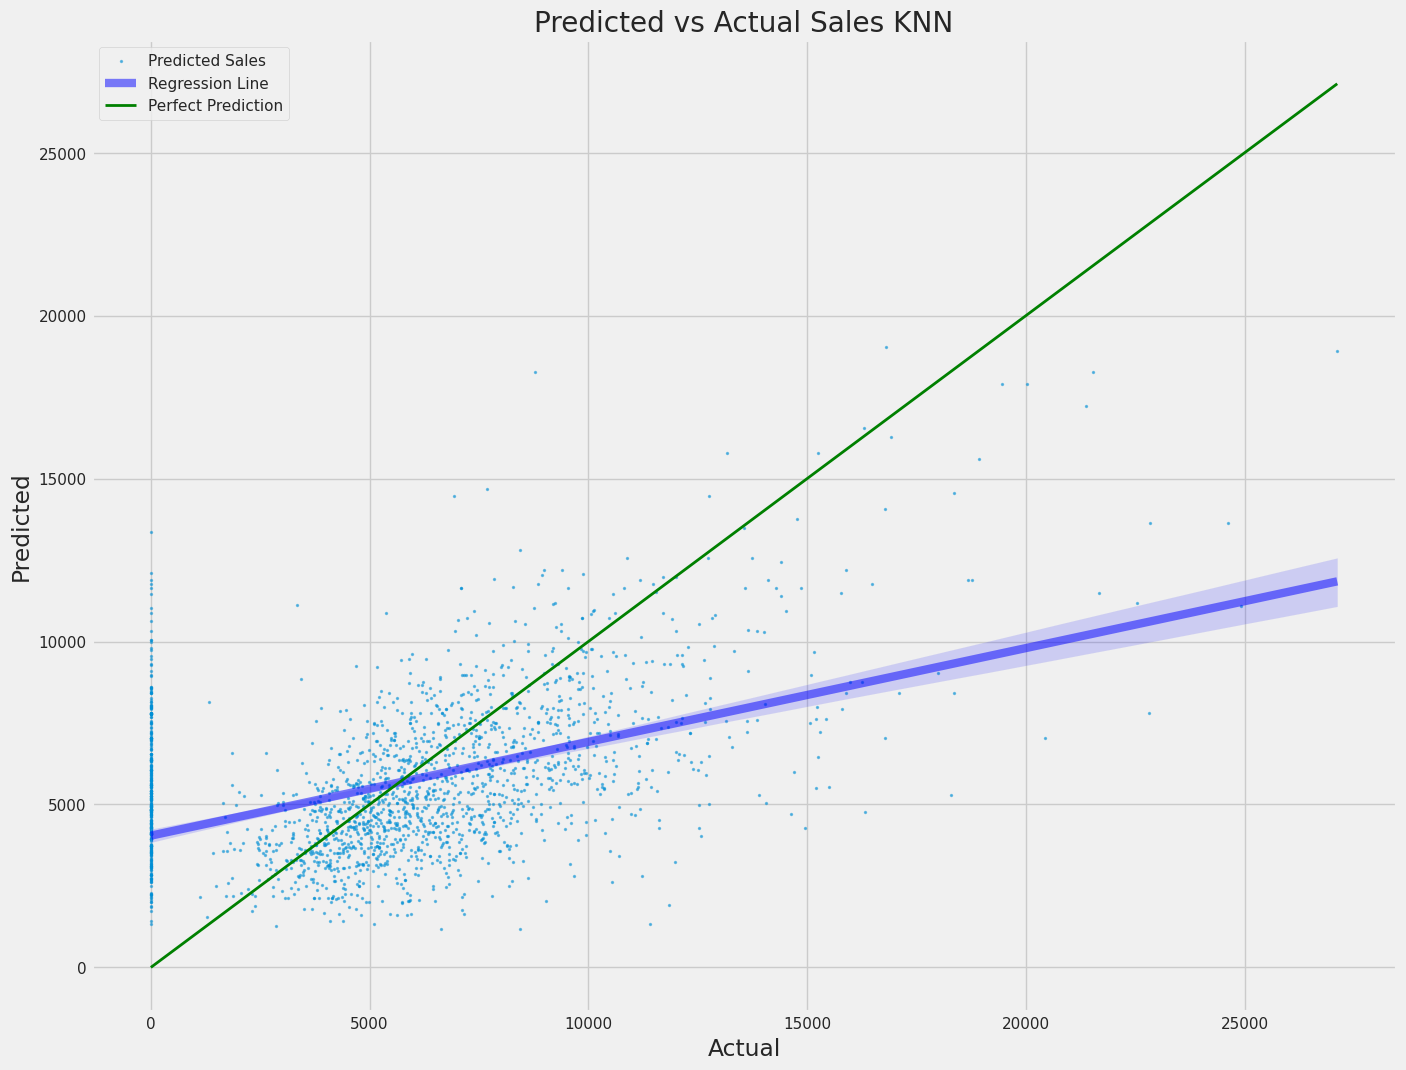

In [34]:
# KNN
from sklearn.neighbors import KNeighborsRegressor

regr = KNeighborsRegressor(n_neighbors=5)

regr = regr.fit(x_train,y_train)

y_pred = regr.predict(x_test)

print("Accuracy:",r2_score(y_test, y_pred))

sns.set_theme(style='darkgrid')
plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,12))
sns.regplot(x=y_test, y=y_pred, truncate=True, scatter_kws={'alpha': 0.5, 's':2}, line_kws={'alpha': 0.5, 'label':'Regression Line', 'color':'blue'}, label='Predicted Sales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2, label='Perfect Prediction', color='green', alpha=1)
plt.title('Predicted vs Actual Sales KNN')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

Accuracy: 0.88899893046127


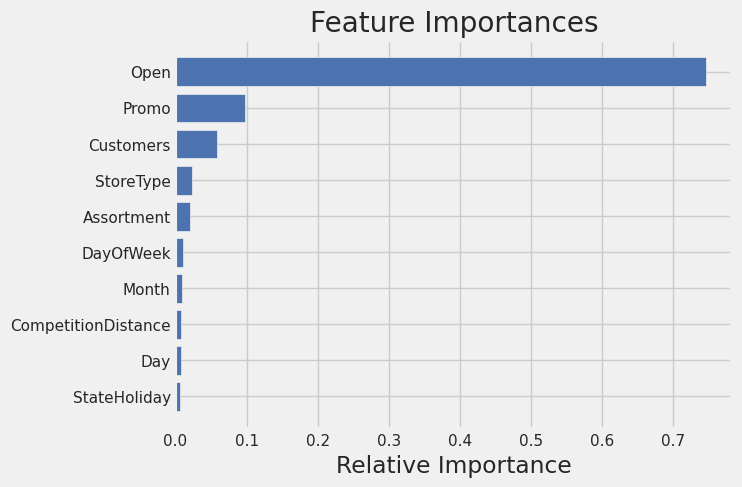

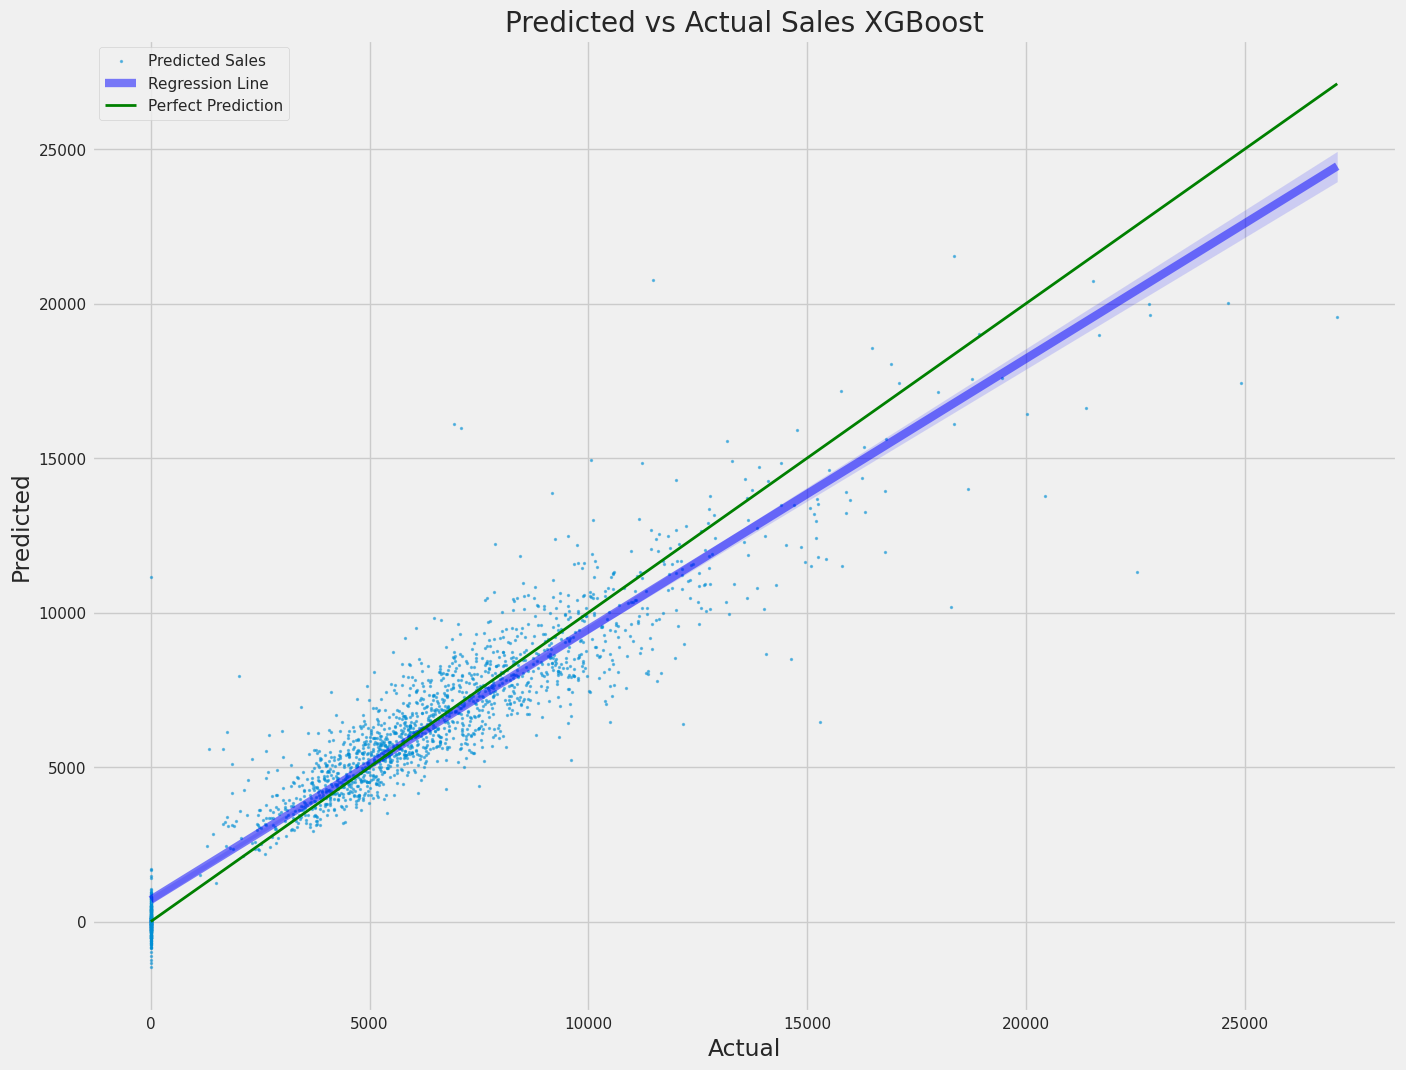

In [35]:
# XGBoost
from xgboost import XGBRegressor


regr = XGBRegressor(random_state=0, n_estimators=100)

# Train XGBRegressor Classifer
regr = regr.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = regr.predict(x_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",r2_score(y_test, y_pred))

#feature importance
def plot_feature_importances_xgb():
    importances = regr.feature_importances_
    features = x.columns
    indices = np.argsort(importances)[-10:]
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()


# Actual vs Predicted Sales Graph with Regression Line and Perfect Prediction Line using Seaborn
def plot_actual_vs_predicted_xgb():  
    sns.set_theme(style='darkgrid')
    plt.style.use('fivethirtyeight')

    plt.figure(figsize=(15,12))
    sns.regplot(x=y_test, y=y_pred, truncate=True, scatter_kws={'alpha': 0.5, 's':2}, line_kws={'alpha': 0.5, 'label':'Regression Line', 'color':'blue'}, label='Predicted Sales')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2, label='Perfect Prediction', color='green', alpha=1)
    plt.title('Predicted vs Actual Sales XGBoost')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.show()

plot_feature_importances_xgb()
plot_actual_vs_predicted_xgb()




In [36]:
# Ein Ensemble/Stacking Modell wird erstellt
from sklearn.ensemble import VotingRegressor

# ein VotingRegressor Objekt wird erstellt
ensemble = VotingRegressor(estimators=[('dt', DecisionTreeRegressor(random_state=0)), ('ab', AdaBoostRegressor(random_state=0, n_estimators=100)), ('gb', GradientBoostingRegressor(random_state=0, n_estimators=100)), ('xgb', XGBRegressor(random_state=0, n_estimators=100))])

# Das Ensemble wird trainiert
ensemble = ensemble.fit(x_train,y_train)

# Die Modellgenauigkeit wird berechnet
print("Accuracy:",r2_score(y_test, y_pred))





Accuracy: 0.88899893046127


In [37]:
df_test=pd.read_csv("test.csv")
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


### Nachdem die Modelle mit den Trainingsdaten trainiert wurden, werden nun die Daten aus dem test.csv für die Vorherhesage des Modells vorbereitet indem die zuvor beschriebenen Datacleaning Funktionen verwendet werden

In [38]:
df_test_merged=merge_df(df1, df_test)
split_date(df_test_merged)
drop_promo2_cols(df_test_merged)
drop_date_col(df_test_merged)
replace_zero(df_test_merged)
label_encoding(df_test_merged)
fill_competition_distance(df_test_merged)
fill_open(df_test_merged)


In [39]:
# Sortiere das df_test_merged dataframe nach Id
df_test_merged.sort_values(by='Id', inplace=True)
df_test_merged.head()
df_test_merged.tail()


,Store,StoreType,Assortment,CompetitionDistance,Id,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
40478,1093,2,2,10450.0,NaN,NaN,1.0,NaN,2,NaN,NaN,NaN,NaN
40527,1095,0,0,690.0,NaN,NaN,1.0,NaN,2,NaN,NaN,NaN,NaN
40624,1098,0,0,1830.0,NaN,NaN,1.0,NaN,2,NaN,NaN,NaN,NaN
41057,1108,0,0,540.0,NaN,NaN,1.0,NaN,2,NaN,NaN,NaN,NaN
41106,1110,2,2,900.0,NaN,NaN,1.0,NaN,2,NaN,NaN,NaN,NaN


In [40]:
df_test_merged.head()

,Store,StoreType,Assortment,CompetitionDistance,Id,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
0,1,2,0,1270.0,1.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0
49,3,0,0,14130.0,2.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0
100,7,0,2,24000.0,3.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0
148,8,0,0,7520.0,4.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0
196,9,0,2,2030.0,5.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0


In [41]:
# Entferne alle Zeilen mit Nullwerten aus df_test_merged
df_test_merged.dropna(inplace=True)

In [42]:
df_test_merged.head()

,Store,StoreType,Assortment,CompetitionDistance,Id,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
0,1,2,0,1270.0,1.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0
49,3,0,0,14130.0,2.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0
100,7,0,2,24000.0,3.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0
148,8,0,0,7520.0,4.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0
196,9,0,2,2030.0,5.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0


In [43]:
# Sortiere das df_test_merged dataframe nach Index
df_test_merged.sort_index(inplace=True)
df_test_merged.head()

,Store,StoreType,Assortment,CompetitionDistance,Id,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
0,1,2,0,1270.0,1.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0
1,1,2,0,1270.0,857.0,3.0,1.0,1.0,0,0.0,2015.0,9.0,16.0
2,1,2,0,1270.0,1713.0,2.0,1.0,1.0,0,0.0,2015.0,9.0,15.0
3,1,2,0,1270.0,2569.0,1.0,1.0,1.0,0,0.0,2015.0,9.0,14.0
4,1,2,0,1270.0,3425.0,7.0,0.0,0.0,0,0.0,2015.0,9.0,13.0


In [44]:
df_customers=df_merged2.copy()

In [45]:
df_customers = df_customers[['Store', 'Customers']]
df_customers.head()

,Store,Customers
0,1,467.646497
1,1,467.646497
2,1,467.646497
3,1,467.646497
4,1,467.646497


In [46]:
# Es wird gezählt wie viele Zeilen mit der gleichen Store-Nummer existieren
df_customers.groupby('Store').count()

# Ingesamt gibt 942 Zeilen mit der gleichen Store-Nummer

# Das df_customers_stores_sorted dataframe wird gebildet indem die Zeilen mit der gleichen Store-Nummer
#  zusammengefasst werden und die Anzahl der Kunden in jeder Zeile addiert wird
df_customers_stores_sorted = df_customers.groupby('Store').sum()


In [47]:
df_customers_stores_sorted.head()

,Customers
Store,
1,440523.0
2,457855.0
3,584310.0
4,1036254.0
5,418588.0


In [48]:
# Für jede Zeile wird der Wert in customers durch 942 geteilt um den Durchschnitt pro Store zu erhalten
df_customers_stores_sorted['Customers'] = df_customers_stores_sorted['Customers'] / 942

In [49]:
df_customers_stores_sorted.head()

,Customers
Store,
1,467.646497
2,486.045648
3,620.286624
4,1100.057325
5,444.360934


In [50]:
# Kombiniere das df_customers_stores_sorted dataframe mit dem df_test_merged dataframe
df_test_merged = pd.merge(df_test_merged, df_customers_stores_sorted, on='Store')

df.test_merged.head()

In [51]:
df_test_merged.head(50)

,Store,StoreType,Assortment,CompetitionDistance,Id,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,Customers
0,1,2,0,1270.0,1.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,467.646497
1,1,2,0,1270.0,857.0,3.0,1.0,1.0,0,0.0,2015.0,9.0,16.0,467.646497
2,1,2,0,1270.0,1713.0,2.0,1.0,1.0,0,0.0,2015.0,9.0,15.0,467.646497
3,1,2,0,1270.0,2569.0,1.0,1.0,1.0,0,0.0,2015.0,9.0,14.0,467.646497
4,1,2,0,1270.0,3425.0,7.0,0.0,0.0,0,0.0,2015.0,9.0,13.0,467.646497
5,1,2,0,1270.0,4281.0,6.0,1.0,0.0,0,0.0,2015.0,9.0,12.0,467.646497
6,1,2,0,1270.0,5137.0,5.0,1.0,0.0,0,0.0,2015.0,9.0,11.0,467.646497
7,1,2,0,1270.0,5993.0,4.0,1.0,0.0,0,0.0,2015.0,9.0,10.0,467.646497
8,1,2,0,1270.0,6849.0,3.0,1.0,0.0,0,0.0,2015.0,9.0,9.0,467.646497
9,1,2,0,1270.0,7705.0,2.0,1.0,0.0,0,0.0,2015.0,9.0,8.0,467.646497


In [52]:
# Das df_test_merged dataframe wird nach Id sortiert
df_test_merged.sort_values(by='Id', inplace=True)

In [53]:
df_test_merged.head(50)

,Store,StoreType,Assortment,CompetitionDistance,Id,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,Customers
0,1,2,0,1270.0,1.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,467.646497
48,3,0,0,14130.0,2.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,620.286624
96,7,0,2,24000.0,3.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,791.474522
144,8,0,0,7520.0,4.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,547.799363
192,9,0,2,2030.0,5.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,479.487261
240,10,0,0,3160.0,6.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,494.332272
288,11,0,2,960.0,7.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,940.543524
336,12,0,2,1070.0,8.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,746.508493
384,13,3,0,310.0,9.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,252.377919
432,14,0,0,1300.0,10.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,522.200637


In [54]:
# Kopiere das df_test_merged dataframe in df_test_merged_raw, welches später für die Vorhersage verwendet wird.
df_test_merged_raw=df_test_merged.copy()

In [55]:
# Enterne die ID Spalte 
df_test_merged_raw.drop(columns=['Id'], inplace=True)

In [56]:
df_test_merged_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,Customers
0,1,2,0,1270.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,467.646497
48,3,0,0,14130.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,620.286624
96,7,0,2,24000.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,791.474522
144,8,0,0,7520.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,547.799363
192,9,0,2,2030.0,4.0,1.0,1.0,0,0.0,2015.0,9.0,17.0,479.487261


In [57]:
# Die Spalte Customers wird an die sechste Stelle verschoben, damit die Anordnung der Spalten mit dem df_train_merged_raw dataframe übereinstimmt,
# was eine Vorraussetzung für die Vorhersage ist.
cols = list(df_test_merged_raw.columns.values)
cols.pop(cols.index('Customers'))
df_test_merged_raw = df_test_merged_raw[['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day']]

In [58]:
df_test_merged_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
0,1,2,0,1270.0,4.0,467.646497,1.0,1.0,0,0.0,2015.0,9.0,17.0
48,3,0,0,14130.0,4.0,620.286624,1.0,1.0,0,0.0,2015.0,9.0,17.0
96,7,0,2,24000.0,4.0,791.474522,1.0,1.0,0,0.0,2015.0,9.0,17.0
144,8,0,0,7520.0,4.0,547.799363,1.0,1.0,0,0.0,2015.0,9.0,17.0
192,9,0,2,2030.0,4.0,479.487261,1.0,1.0,0,0.0,2015.0,9.0,17.0


In [59]:
# Die Vorhersage wird durchgeführt und in Sales gespeichert
preds = ensemble.predict(df_test_merged_raw)

In [60]:
# Sortiere das df_test_merged dataframe nach Id
df_test_merged.sort_values(by='Id', inplace=True)

In [61]:
print(preds)


[ 6479.42449695  8442.1958251   9986.30175477 ...  6085.15502181
 19546.93200233  6199.96445589]


In [62]:
#für die Submission wird ein neues dataframe erstellt bestehend aus der Id Spalte aus dem test_merged Dataframe und den Sales Vorhersagen
submission_df=pd.DataFrame({"Id": df_test_merged["Id"], "Sales": preds})

In [63]:
#Die ID Spalte wird in den Int Typ umgewandelt, da es ein Voraussetzung für die Submission bei Kaggle ist
submission_df['Id'] = submission_df['Id'].astype(int)

In [64]:
# Das submission_df dataframe wird in einer csv Datei gespeichert
submission_df.to_csv("submission.csv", index=False, header=True, sep=',', encoding='utf-8')

In [65]:
#Überprüfung ob alle Ids aus dem test Dataframe in der submission_df vorhanden sind
df_test[~df_test['Id'].isin(df_test_merged['Id'])]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday


# Kapitel 4: Auswertung
## In diesem Kapitel werden zwei reißerische Grafiken dargestellt, welche mit den KI-Modellen in Verbindung gebracht werden

# Erste Beoabachtung: Auswertung unseres XGBoost Modelles

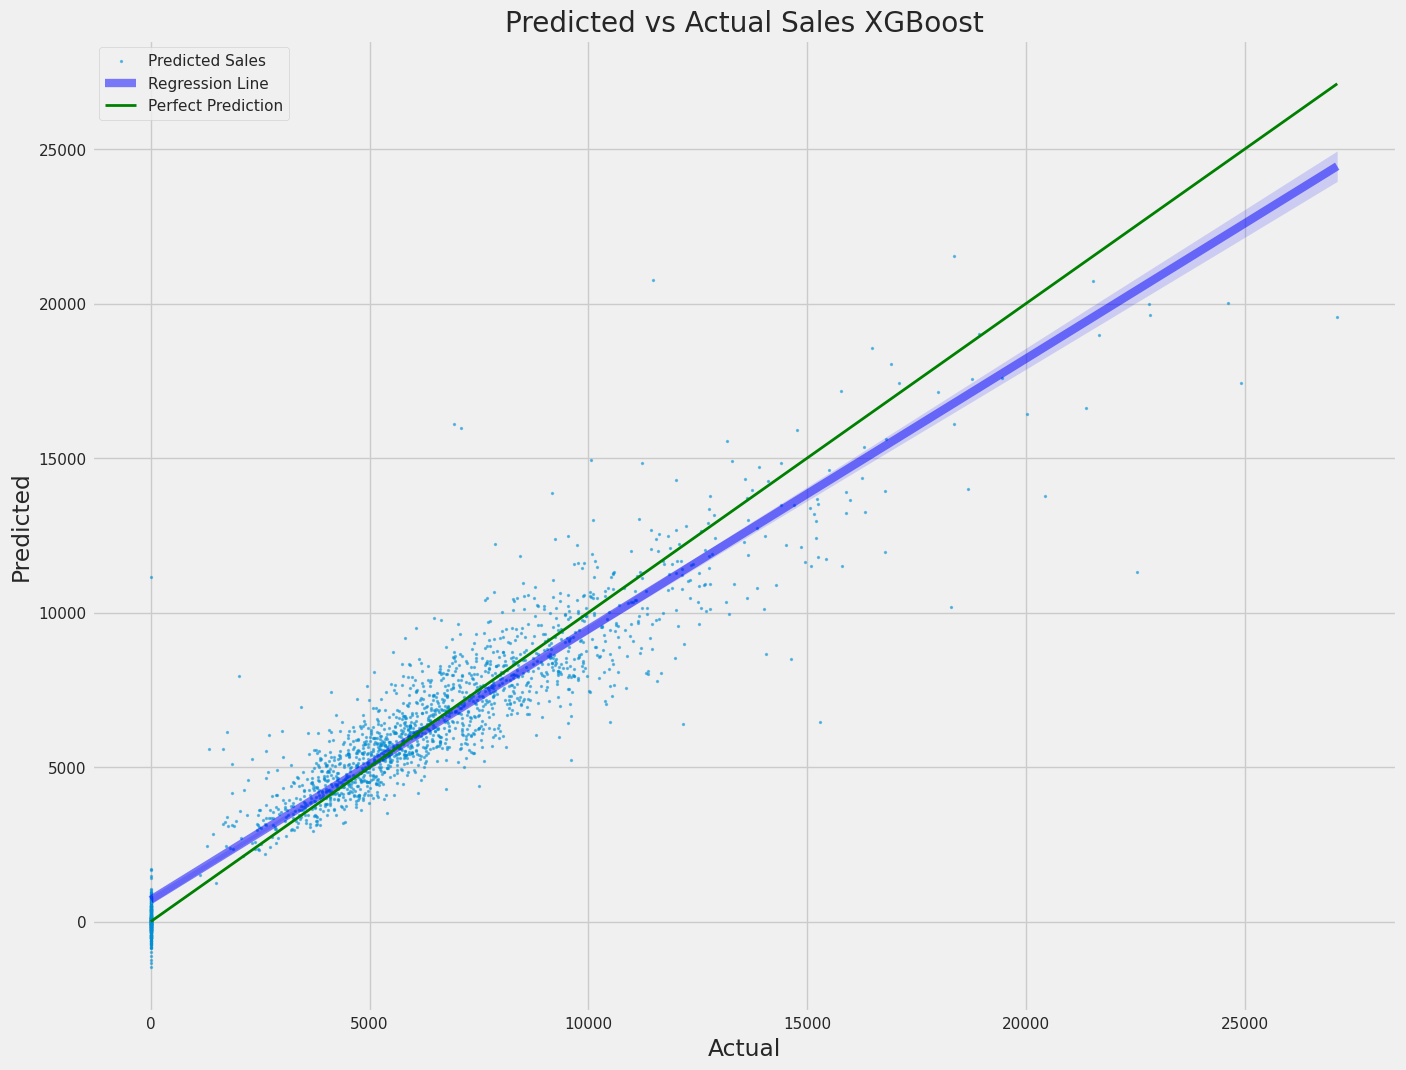

In [66]:
plot_actual_vs_predicted_xgb()

## Storytelling Grafik 1
In der oberen Grafik sehen wir unter anderem folgende drei Merkmale
* Vorhergesagte Umsatzahlen (Predicted Sales)
* Eine Regressions Linie, welche aus einer Punktwolke der "Predicted Sales" ermittelt wird und unsere Vorhersage mit der Perfekten Vorhersage vergleicht
* Die Perfekte Vorhersage, welches wir mit unserem Modell anstreben (Perfect Prediction)

Zu erkennen ist, dass das Modell zu ≈ 89% die korrekten Umsätze bestimmt und somit die meisten Umsätze richtig vorhersagen kann.
Die Regressionslinie liegt nah an der perfekten Vorhersage und ist somit das Modell mit welcher wir am besten abgeschnitten haben.

Für dieses Modell wurde das XGBoost Verfahren verwendet, welches das zuverlässigste Modell unserer aufgeführten Modelle ist.

# Zweite Beobachtung: Vergleich der Feature Importances bei verschiedenen KI-Modellen

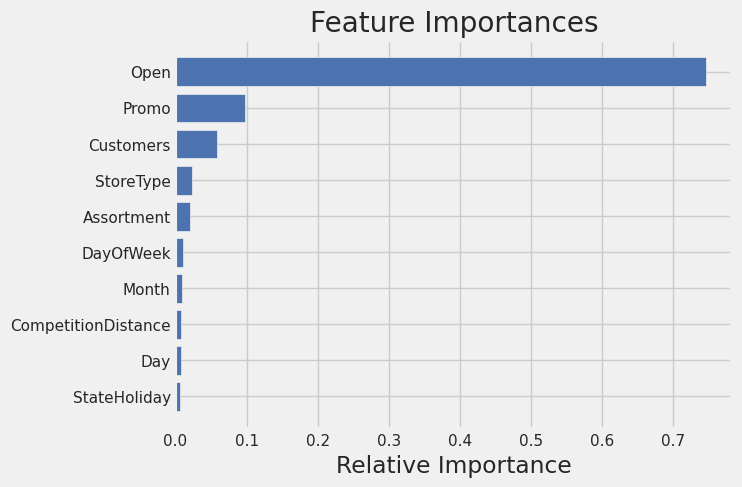

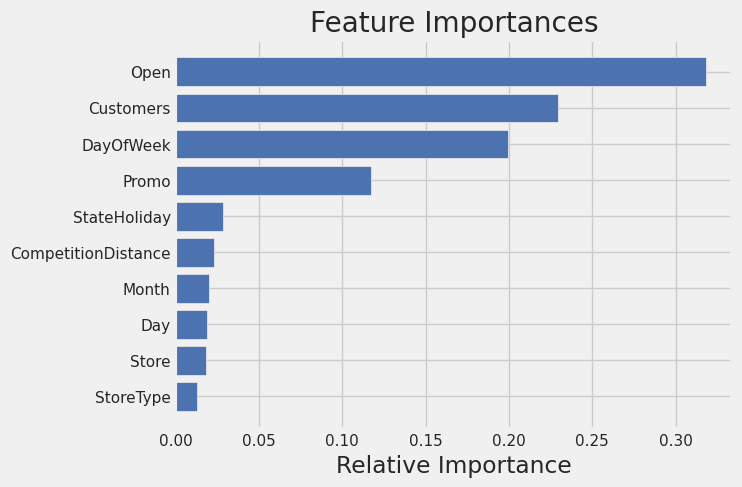

In [67]:
plot_feature_importances_xgb()
plot_feature_importances_rfr()


## Storytelling Grafik 2
In dieser Grafik haben wir uns dazu entschieden eine Gegenüberstellung der wichtigsten Features (Spalten), für die verschiedenen Modelle von XGBoost, unserem besten Modell, und dem RandomForest Modell, welches schlechter abgeschnitten hat, aufzuzeigen.

**Info:** Den Punkt "Open" wurde in der folgenden Beschreibung ausgelassen, da sich die Modelle immer auf den Ausgangspunkt auslegen, dass das Geschäft, um Umsätze zu generieren, Geöffnet sein muss.

#### XGBoost Modell
Spannend zu erkennen ist, das bei unserem Modell von XGBoost die Werbeaktionen (Promo) eine sehr wichtige Rolle in der Auswertung gespielt haben.
Als zweites kommen natürlich die Kunden, denn ohne diese, würde das Geschäft nicht laufen.
Folgend noch zwei ähnlich wichtige Aspekte, welche jedoch deutlich unter die oberen fallen:
* StoreType, verschiedene Arten von Geschäften
* Assortment, welches das Sortiment beschreibt
Weitergehend kommen ähnlich, aber auch eher unwichtigere Aspekte hinzu:
* DayOfWeek
* Month
* CompetitionDistance
* Day
* StateHoliday

#### RandomForest Modell
In unserem Modell des RandomForest haben wir jedoch die Kunden an erster Stelle und folgend den Tag der Woche.
Hierbei ist zu erkennen das ein bestimmer Wochentag einen deutlich größeren Einfluss auf die Auswertung hat als die Werbeaktionen.
Jedoch sind die Werbeaktionen hierbei auch weit oben und kommen an dritter Stelle.
Weitergehend kommen die folgenden Aspekte, welche eine ungefähre gleich bleibende Auswirkung auf die Vorhersahe hat:
* StateHoliday
* CompetitionDistance
* Month
* Day
* Store
* Storetype